In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Load Data

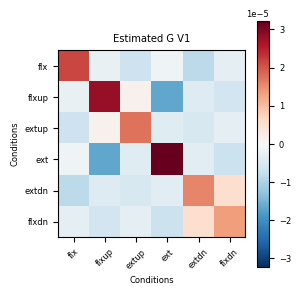

In [22]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'V1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

# load dataset:
file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
D = np.load(file_path_save, allow_pickle=True)
D = D['Y'].tolist()

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# visualize the estimated G:
G_mean = np.mean(G_hat[0:24,:,:], axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



# Build models

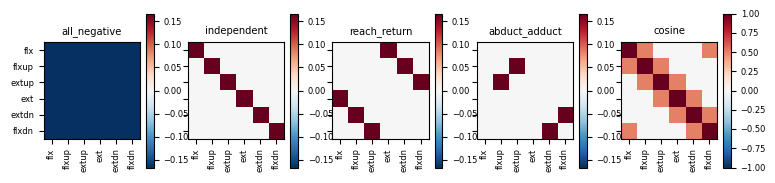

In [6]:
ncond = 6
M = []
modelG = {}
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

# all negative:
cov = np.ones((ncond,ncond)) * -1
cov = cov / np.abs(np.trace(cov))
modelG['all_negative'] = [cov]

# independent model
cov = np.eye(ncond)
cov = cov/np.trace(cov)
modelG['independent'] = [cov]

# reach and return:
covs = np.tile(np.eye(ncond//2), (2,2)) - np.eye(ncond)
# covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
covs = covs/covs.shape[0]
M_reach_return = pcm.FixedModel('reach_return', covs)
modelG['reach_return'] = [covs]

# abduct adduct:
# covs = np.zeros((ncond,ncond))
covs = np.zeros((ncond,ncond))
covs[1,2] = 1
covs[2,1] = 1
covs[4,5] = 1
covs[5,4] = 1
# covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
covs = covs/covs.shape[0]
M_abduct_adduct = pcm.FixedModel('abduct_adduct', covs)
modelG['abduct_adduct'] = [covs]

# Cosine tuning curve model:
angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
corr = np.cos(delta)
# Truncate the cosine: only positive correlations for angles <= 90 deg
# Calculate absolute angular difference in degrees, handling wrap-around
delta_deg = np.abs(angles_deg[:, None] - angles_deg[None, :])
delta_deg = np.minimum(delta_deg, 360 - delta_deg)
# Create a mask for angles > 90 degrees
mask = delta_deg > 90
corr[mask] = 0
# corr = pcm.centering(ncond) @ corr @ pcm.centering(ncond)
M_cosine = pcm.FixedModel('cosine', corr)
modelG['cosine'] = [corr]

# ===== Component Models =====
M.append(pcm.ComponentModel('reach_return',[modelG['independent'][0],modelG['reach_return'][0]]))
M.append(pcm.ComponentModel('abduct_adduct',[modelG['independent'][0],modelG['abduct_adduct'][0]]))
M.append(pcm.ComponentModel('cosine',[modelG['independent'][0],modelG['cosine'][0]]))
M.append(pcm.ComponentModel('reach_return+abduct_adduct',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0]]))
M.append(pcm.ComponentModel('reach_return+cosine',[modelG['independent'][0],modelG['reach_return'][0],modelG['cosine'][0]]))
M.append(pcm.ComponentModel('all',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['cosine'][0]]))

cmap = 'RdBu_r'
model_names = list(modelG.keys())
n = len(model_names)
fix, ax = plt.subplots(1, n, figsize=(9,2), sharey=True)
for i, name in enumerate(model_names):
    vmin = -np.max(np.abs(modelG[name][0]))
    vmax = np.max(np.abs(modelG[name][0]))
    ax[i].imshow(modelG[name][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(name)
    ax[i].set_xticks([0,1,2,3,4,5])
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[name][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit CKA

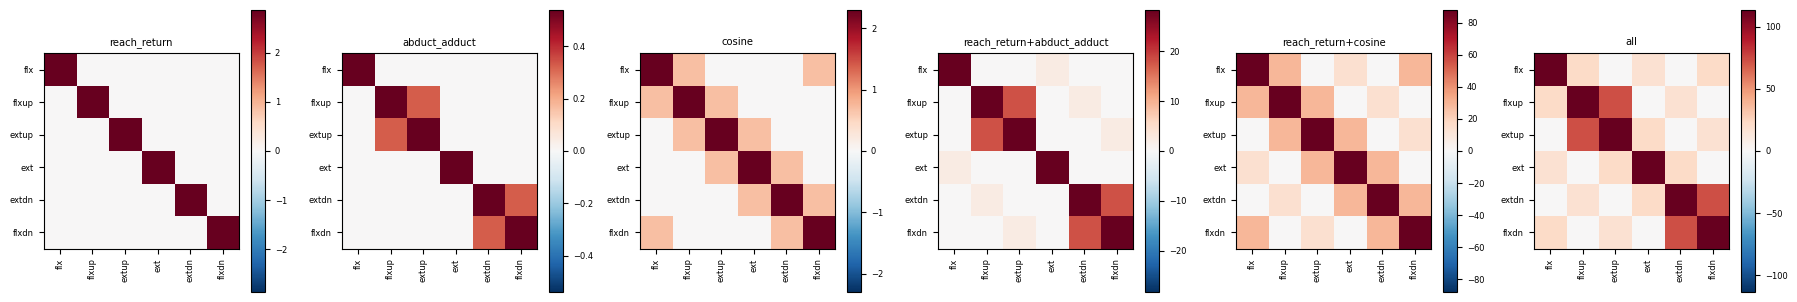

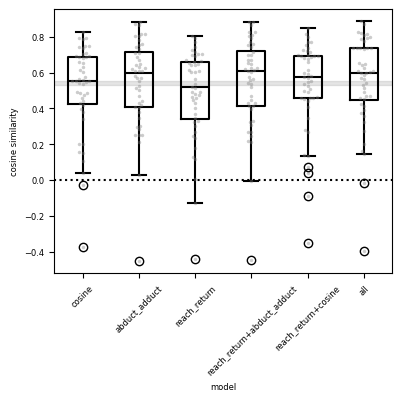

T-test abduct_adduct > cosine: t(47) = 2.197, p = 0.0165
T-test cosine > reach_return: t(47) = 2.724, p = 0.0045
T-test cosine > reach_return+abduct_adduct: t(47) = -2.347, p = 0.9884
T-test reach_return > cosine: t(47) = -2.724, p = 0.9955
T-test reach_return > cosine: t(47) = -2.724, p = 0.9955
T-test reach_return > abduct_adduct: t(47) = -4.883, p = 1.0000
T-test reach_return+abduct_adduct > reach_return: t(47) = 5.192, p = 0.0000
T-test reach_return+abduct_adduct > abduct_adduct: t(47) = 1.947, p = 0.0288
T-test reach_return+cosine > reach_return+abduct_adduct: t(47) = -1.626, p = 0.9446
T-test all > reach_return: t(47) = 5.756, p = 0.0000
T-test all > reach_return+abduct_adduct: t(47) = 1.183, p = 0.1214
T-test all > reach_return+cosine: t(47) = 3.050, p = 0.0019
Best model based on mean CKA: reach_return


In [ ]:
N = len(D)

T_ind, theta_ind, AIC = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose=False, AIC=True)
T, theta, ceil = fit_CKA_group_crossval(D, M, fixed_effect='block', theta0=None, verbose = False, ceil=True)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(3*nmodels,3))
th = []
for m in range(nmodels):
    th_tmp = np.exp(theta[m])
    th_tmp = np.median(th_tmp, axis=1)
    th_tmp = np.log(th_tmp)
    th.append(th_tmp)
    
    G_pred = M[m].predict(th[m][:M[m].n_param])[0]
    vmin = -np.max(np.abs(G_pred))
    vmax = np.max(np.abs(G_pred))
    ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[m].set_xticks(list(range(ncond)))
    ax[m].set_xticklabels(labels, rotation=90)
    ax[m].set_yticks(list(range(ncond)))
    ax[m].set_yticklabels(labels)
    ax[m].set_title(f'{M[m].name}')
    plt.colorbar(ax[m].imshow(G_pred, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[m])
plt.tight_layout()
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model', future_stack=True)        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA'].copy()
ceil_high = np.mean(ceil['ceil_high'])
ceil_low = np.mean(ceil['ceil_low'])
plt.figure(figsize=(4,4))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5, order=['cosine','abduct_adduct','reach_return','reach_return+abduct_adduct','reach_return+cosine','all'])
sns.swarmplot(data=T_cka, x='model', y='value', color='gray', size=2.5, alpha=0.4, order=['cosine','abduct_adduct','reach_return','reach_return+abduct_adduct','reach_return+cosine','all'])
plt.axhline(y=0, color='black', linestyle=':')
# make a zone for ceiling:
plt.axhspan(ceil_low, ceil_high, color='gray', alpha=0.2, label='Ceiling')
plt.xticks(rotation=45)
plt.ylabel('cosine similarity')
plt.tight_layout()
plt.show()

# t-test one sided m2 > m1:
m1 = 'cosine'
m2 = 'abduct_adduct'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return'
m2 = 'cosine'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return+abduct_adduct'
m2 = 'cosine'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'cosine'
m2 = 'reach_return'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'cosine'
m2 = 'reach_return'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'abduct_adduct'
m2 = 'reach_return'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return'
m2 = 'reach_return+abduct_adduct'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'abduct_adduct'
m2 = 'reach_return+abduct_adduct'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return+abduct_adduct'
m2 = 'reach_return+cosine'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return'
m2 = 'all'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return+abduct_adduct'
m2 = 'all'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

m1 = 'reach_return+cosine'
m2 = 'all'
data1 = T_cka[T_cka['model'] == m1]['value']
data2 = T_cka[T_cka['model'] == m2]['value']
t_stat, p_value = stats.ttest_rel(data2, data1, alternative='greater')
print(f'T-test {m2} > {m1}: t({len(data1)-1}) = {t_stat:.3f}, p = {p_value:.4f}')

# pick best model based on median CKA:
mean_cka = T_cka.groupby('model')['value'].mean()
best_model = mean_cka.idxmax()
best_model = 'reach_return+abduct_adduct'
best_model = 'reach_return'
# best_model = 'all'
print(f'Best model based on mean CKA: {best_model}')

# save the best G:
i = [idx for idx, m in enumerate(M) if m.name == best_model][0]
G_pred = M[i].predict(th[i][:M[i].n_param])[0]

file_path_save = os.path.join(analysisDir, f'best_within_model_{region}.npz')
np.savez(file_path_save, G_hat=G_pred)




# Plot G_hat

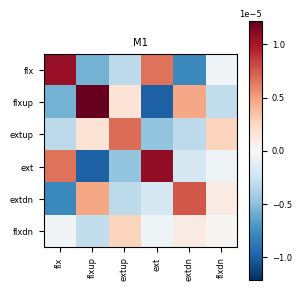

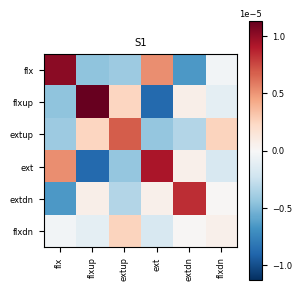

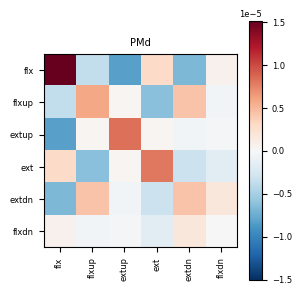

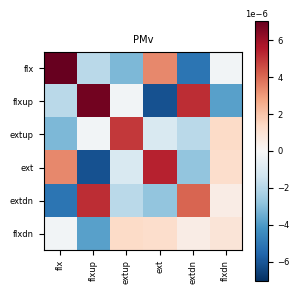

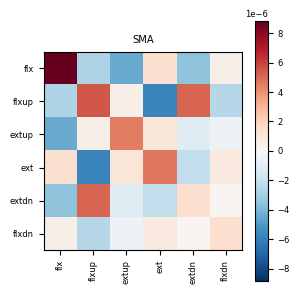

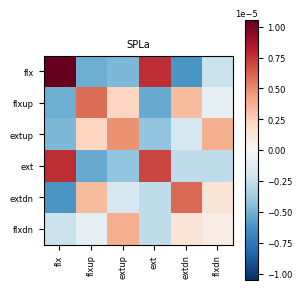

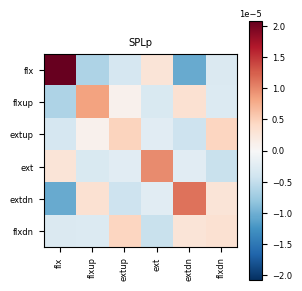

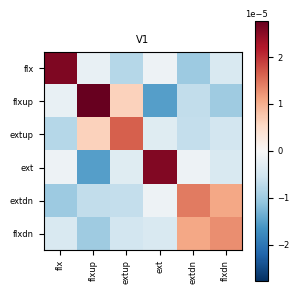

In [15]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
ncond = 6

for region in regions:
    # load dataset:
    file_path_save = os.path.join(analysisDir, f'pcm_dataset_6by6_{region}.npz')
    D = np.load(file_path_save, allow_pickle=True)
    D = D['Y'].tolist()

    # data g matrix:
    N = len(D)
    G_hat = np.zeros((N, ncond, ncond))
    for i in range(N):
        G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                                D[i].obs_descriptors['cond_vec'],
                                                D[i].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

    # PLOT:
    matplotlib.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    G_mean = np.mean(G_hat[:,:,:], axis=0)
    vmin = -np.max(np.abs(G_mean))
    vmax = np.max(np.abs(G_mean))
    ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.set_xticks(list(range(ncond)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(list(range(ncond)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{region}')
    plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
    plt.tight_layout()
    plt.show()

